In [2]:
import pandas as pd

ROOT_PATH = "/data/rsg/nlp/yujieq/bms/"
gold = pd.read_csv(ROOT_PATH + 'data/valid_folds.csv')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


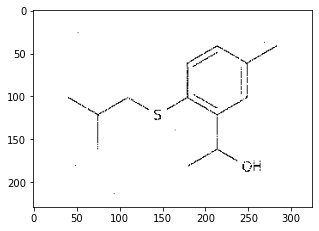

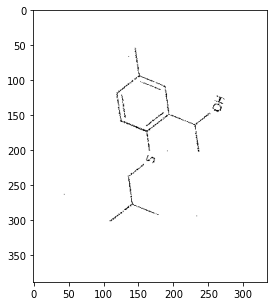

In [27]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_train_file_path(image_id):
    return ROOT_PATH + "data/train/{}/{}/{}/{}.png".format(image_id[0], image_id[1], image_id[2], image_id)

def visualize(image):
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.show()

file_path = get_train_file_path("000011a64c74")
image = cv2.imread(file_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)

visualize(image)

# transform = A.SafeRotate(border_mode=cv2.BORDER_CONSTANT)
# plt.imshow(transform(image=image)['image'])
transform = torchvision.transforms.RandomRotation(90, expand=True, fill=255)
transformed_image = transform(Image.fromarray(image.astype(np.uint8)))
visualize(transformed_image)

# Atrans = A.Compose([
#         A.Affine(rotate=(-30,30), fit_output=True),
#         A.Resize(384, 384),
#         A.Normalize(
#             mean=[0.485, 0.456, 0.406],
#             std=[0.229, 0.224, 0.225],
#         ),
# #         ToTensorV2(),
#     ])
# visualize(Atrans(image=image)['image'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(229, 325, 3)


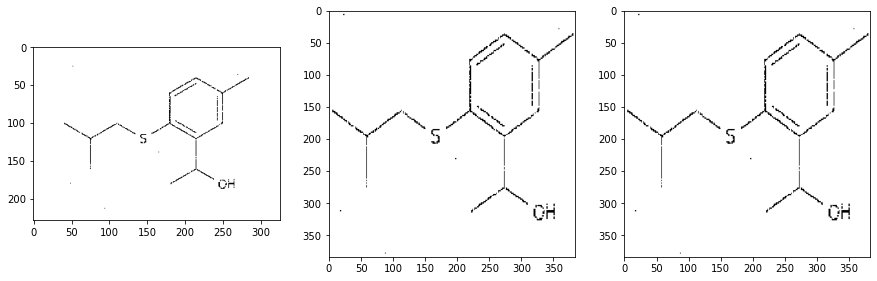

In [98]:
from albumentations.augmentations.geometric.functional import safe_rotate_enlarged_img_size, _maybe_process_in_chunks
import PIL

def expand_safe_rotate(
    img: np.ndarray,
    angle: int = 0,
    interpolation: int = cv2.INTER_LINEAR,
    value: int = None,
    border_mode: int = cv2.BORDER_REFLECT_101,
):

    old_rows, old_cols = img.shape[:2]

    # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape
    image_center = (old_cols / 2, old_rows / 2)

    # Rows and columns of the rotated image (not cropped)
    new_rows, new_cols = safe_rotate_enlarged_img_size(angle=angle, rows=old_rows, cols=old_cols)

    # Rotation Matrix
    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)

    # Shift the image to create padding
    rotation_mat[0, 2] += new_cols / 2 - image_center[0]
    rotation_mat[1, 2] += new_rows / 2 - image_center[1]

    # CV2 Transformation function
    warp_affine_fn = _maybe_process_in_chunks(
        cv2.warpAffine,
        M=rotation_mat,
        dsize=(new_cols, new_rows),
        flags=interpolation,
        borderMode=border_mode,
        borderValue=value,
    )

    # rotate image with the new bounds
    rotated_img = warp_affine_fn(img)

    return rotated_img

class ExpandSafeRotate(A.SafeRotate):

    def __init__(
        self,
        limit=90,
        interpolation=cv2.INTER_LINEAR,
        border_mode=cv2.BORDER_REFLECT_101,
        value=None,
        mask_value=None,
        always_apply=False,
        p=0.5,
    ):
        super(ExpandSafeRotate, self).__init__(
            limit=limit,
            interpolation=interpolation,
            border_mode=border_mode,
            value=value,
            mask_value=mask_value,
            always_apply=always_apply,
            p=p)

    def apply(self, img, angle=0, interpolation=cv2.INTER_LINEAR, **params):
        return expand_safe_rotate(
            img=img, value=self.value, angle=angle, interpolation=interpolation, border_mode=self.border_mode
        )

class CropWhite(A.DualTransform):
    
    def __init__(self, value=255, pad=0):
        super(CropWhite, self).__init__(always_apply=True)
        self.value = value
        self.pad = pad
        assert pad >= 0
        
    def apply(self, img, **params):
        x = (img != self.value).sum(axis=2)
        if x.sum() == 0:
            return img
        row_sum = x.sum(axis=1)
        u = 0
        while row_sum[u] == 0:
            u += 1
        u = max(0, u-self.pad)
        d = len(row_sum)
        while row_sum[d-1] == 0:
            d -= 1
        d = min(len(row_sum), d+self.pad)
        col_sum = x.sum(axis=0)
        l = 0
        while col_sum[l] == 0:
            l += 1
        l = max(0, l-self.pad)
        r = len(col_sum)
        while col_sum[r-1] == 0:
            r -= 1
        r = min(len(col_sum), r+self.pad)
        img = img[u:d, l:r]
        return img
    
    
class ResizePad(A.DualTransform):

    def __init__(self, height, width, interpolation=cv2.INTER_LINEAR, value=(255,255,255)):
        super(ResizePad, self).__init__(always_apply=True)
        self.height = height
        self.width = width
        self.interpolation = interpolation
        self.value = value

    def apply(self, img, interpolation=cv2.INTER_LINEAR, **params):
        h, w, _ = img.shape
        img = A.augmentations.geometric.functional.resize(
            img, 
            height=min(h, self.height), 
            width=min(w, self.width), 
            interpolation=interpolation
        )
        h, w, _ = img.shape
        pad_top = (self.height - h) // 2
        pad_bottom = (self.height - h) - pad_top
        pad_left = (self.width - w) // 2
        pad_right = (self.width - w) - pad_left
        img = A.augmentations.pad_with_params(
            img,
            pad_top,
            pad_bottom,
            pad_left,
            pad_right,
            border_mode=cv2.BORDER_CONSTANT,
            value=self.value,
        )
        return img

    
def visualize(image, org_image, aug_image):
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.subplot(1,3,2)
    plt.imshow(org_image)
    plt.subplot(1,3,3)
    plt.imshow(aug_image)
    plt.show()


Atrans = A.Compose([
        ExpandSafeRotate(limit=90, border_mode=cv2.BORDER_CONSTANT, interpolation=cv2.INTER_NEAREST, value=(255,255,255)),
        CropWhite(pad=3),
#         ResizePad(384, 384, interpolation=cv2.INTER_NEAREST),
        A.Resize(384, 384, interpolation=cv2.INTER_NEAREST),
#         A.Normalize(
#             mean=[0.485, 0.456, 0.406],
#             std=[0.229, 0.224, 0.225],
#         ),
#         ToTensorV2(),
    ])

Otrans = A.Compose([
        CropWhite(pad=3),
#         ResizePad(384, 384, interpolation=cv2.INTER_NEAREST),
        A.Resize(384, 384, interpolation=cv2.INTER_NEAREST),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ])


for image_id in gold['image_id'].values[:1]:
    file_path = get_train_file_path(image_id)
    image = cv2.imread(file_path)
    print(image.shape)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    org_image = Otrans(image=image)['image']
    aug_image = Atrans(image=image)['image']
#     org_image = np.clip(org_image, 0, 1) * 255
#     print(org_image)
#     cv2.imwrite('tmp.png', org_image)
    visualize(image, org_image, aug_image)

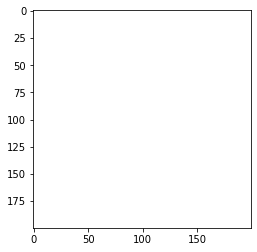

In [106]:
s= 'COc1ccccc1-n1[nH]c(C(=N)O)c2c1C(=O)N(c1ccc(N3CCC3=O)c(C)c1)CC2'
mol = Chem.MolFromSmiles(s)
# mol = Chem.MolFromInchi('InChI=1S/H2O/h1H2')
mol = Chem.MolFromSmiles('C')
print(mol)
img = Draw.MolsToGridImage([mol], subImgSize=(200, 200), molsPerRow=1)
plt.imshow(img)
img = np.array(img)
img = Atrans(image=img)['image']

In [182]:
from tqdm import tqdm

sizes = []

for image_id in tqdm(gold['image_id'].values[:10000]):
    file_path = get_train_file_path(image_id)
    image = cv2.imread(file_path)
    assert(image[:,:,0] == image[:,:,1]).all()
    assert(image[:,:,0] == image[:,:,2]).all()
    h, w, c = image.shape
    sizes.append([h, w])


  0%|          | 0/242419 [00:06<?, ?it/s]30.47it/s]

100%|██████████| 10000/10000 [01:49<00:00, 91.27it/s][A


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Cc1c(C(O)=Nc2nccs2)c2ccccn2c1C(=O)c1ccc(F)cc1


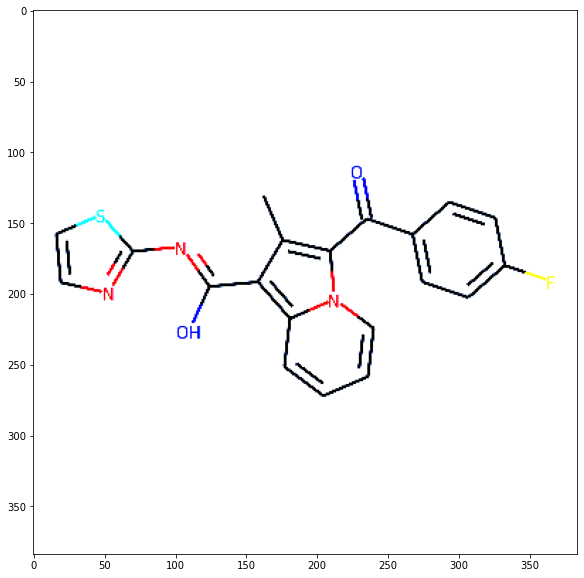

In [66]:
import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
import numpy as np

smiles = gold.loc[6, 'SMILES']
print(smiles)

mol = Chem.MolFromSmiles(smiles)
img = Draw.MolsToGridImage([mol], subImgSize=(384,384), molsPerRow=1)
img = np.array(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
img = Otrans(image=img)['image']
plt.figure(figsize=(10,10))
plt.imshow(img)

In [47]:
mol1 = Chem.MolFromSmiles("CSCC")
mol2 = Chem.MolFromSmiles("CCSC")
print(Chem.MolToInchi(mol1))
print(Chem.MolToInchi(mol2))

InChI=1S/C3H8S/c1-3-4-2/h3H2,1-2H3
InChI=1S/C3H8S/c1-3-4-2/h3H2,1-2H3
